# Get Ralphs locations

#### Load Python tools and Jupyter config

In [1]:
%load_ext lab_black

In [2]:
import json
import requests
import pandas as pd
import geopandas as gpd
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm, trange
from random import randint
from time import sleep

In [3]:
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = None

## Read data

#### All the locations

#### California ZIP Codes from [Esri](https://hub.arcgis.com/datasets/CalEMA::census-2020-california-zip5-postal-code-areas/about)

In [4]:
zips = gpd.read_file(
    "https://services.arcgis.com/BLN4oKB0N1YSgvY8/arcgis/rest/services/CA_ZCTA_2020/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
)[["GEOID20", "INTPTLAT20", "INTPTLON20", "geometry"]].rename(
    columns={"GEOID20": "zip", "INTPTLAT20": "lat", "INTPTLON20": "lng"}
)

In [5]:
zips["lat"] = zips["lat"].astype(float)
zips["lng"] = zips["lng"].astype(float)

In [6]:
so_cal = zips.query("lat < 36 and lng < -115")

<AxesSubplot: >

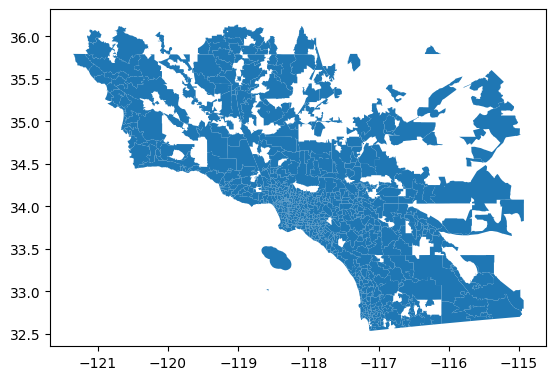

In [7]:
so_cal.plot()

In [8]:
len(so_cal)

805

#### Loop through the list to set a search radius in each ZIP

In [9]:
stores_list = []

headers = {
    "authority": "www.ralphs.com",
    "accept": "application/json, text/plain, */*",
    "user-agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
    "x-call-origin": '{"component":"store locator","page":"store locator"}',
}

for k, v in tqdm(so_cal.head(500).iterrows()):

    params = {
        "filter.latLng": [
            v["lat"],
            v["lng"],
        ],
        "projections": "full",
    }

    response = requests.get(
        "https://www.ralphs.com/atlas/v1/stores/v2/locator",
        params=params,
        headers=headers,
    )

    src = pd.DataFrame(response.json()["data"]["stores"])
    stores_list.append(src)
    sleep(randint(1, 3))

0it [00:00, ?it/s]

In [10]:
df = (
    pd.concat(stores_list)
    .query('brand == "RALPHS"')[
        [
            "facilityName",
            "locale",
            "vanityName",
            "banner",
            "locationId",
            "open24Hours",
            "phoneNumber",
        ]
    ]
    .reset_index(drop=True)
)

In [11]:
df[
    [
        "address.addressLines",
        "address.cityTown",
        "address.name",
        "address.postalCode",
        "address.stateProvince",
        "address.residential",
        "address.countryCode",
        "location.lat",
        "location.lng",
    ]
] = pd.json_normalize(df["locale"])

In [12]:
df["address"] = df["address.addressLines"].apply(pd.Series)

In [13]:
df["phone"] = pd.json_normalize(df["phoneNumber"])["pretty"]

In [14]:
df = df.drop(["locale", "phoneNumber", "address.addressLines"], axis=1)

In [15]:
df.columns = (
    df.columns.str.lower()
    .str.replace("address.", "", regex=False)
    .str.replace("location.", "", regex=False)
)

In [16]:
df_slim = (
    df[
        [
            "locationid",
            "name",
            "citytown",
            "address",
            "stateprovince",
            "phone",
            "postalcode",
            "lat",
            "lng",
        ]
    ]
    .drop_duplicates()
    .reset_index(drop=True)
    .copy()
)

In [24]:
df_slim.head()

,locationid,name,citytown,address,stateprovince,phone,postalcode,lat,lng
0,70300016,Wiltern,Los Angeles,670 S Western Ave,CA,(213) 383-5058,90005,34.060044,-118.308496
1,70300032,Third Street,Los Angeles,3410 W 3Rd St,CA,(213) 480-1421,90020,34.068413,-118.290571
2,70300291,Pico San Vincente,Los Angeles,4760 W Pico Blvd,CA,(323) 937-4107,90019,34.047832,-118.339401
3,70300039,La Brea,Los Angeles,260 S La Brea Ave,CA,(323) 937-3264,90036,34.070027,-118.343587
4,70300294,Renaissance Plaza,Los Angeles,2600 S Vermont Ave,CA,(323) 732-3863,90007,34.031799,-118.290775


---

## Geography

#### Make a geodataframe from lon/lat

In [18]:
df_geo = df_slim.copy()

In [19]:
gdf = gpd.GeoDataFrame(
    df_geo, geometry=gpd.points_from_xy(df_geo.lng, df_geo.lat)
).set_crs("epsg:4326")

<AxesSubplot: >

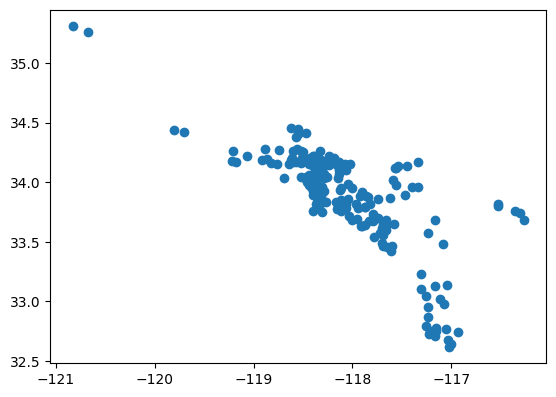

In [20]:
gdf.plot()

---

## Exports

#### CSV

In [21]:
df.to_csv("data/processed/ralphs_locations.csv", index=False)

#### JSON

In [22]:
df.to_json("data/processed/ralphs_locations.json", indent=4, orient="records")

#### GeoJSON

In [23]:
gdf.to_file("data/processed/ralphs_locations.geojson", driver="GeoJSON")